# I. Import Libraries

Let's start by reading the file to understand its structure and content. This will help in providing an overview of the data you mentioned. I'll read the file and display the first few rows to get a sense of the data.

The dataset contains information on the betting activity of individual customers for specific days. Here's an overview of the columns and their potential meanings:

- `DATE_DIM`: The date of the betting activity.
- `DAY_OF_WEEK`: The day of the week for the betting activity.
- `BET_ACCOUNT_NUM_HASH`: A unique identifier for each customer.
- `AGE`: The age of the customer.
- `AGE_BAND`: The age band or range the customer falls into.
- `GENDER`: The gender of the customer.
- `TENURE_IN_DAYS`: How long the customer has been with the service, in days.
- `RESIDENTIAL_STATE`: The state of residence of the customer.
- `FOB_RACING_TURNOVER`: Turnover from fixed odds betting on racing.
- `FOB_SPORT_TURNOVER`: Turnover from fixed odds betting on sports.
- `PARI_RACING_TURNOVER`: Turnover from pari-mutuel betting on racing.
- `PARI_SPORT_TURNOVER`: Turnover from pari-mutuel betting on sports.
- `TOTAL_TURNOVER`: The total betting turnover for the customer on that day.
- `DIVIDENDS_PAID`: The total dividends paid out to the customer on that day.
- `GROSS_MARGIN`: The gross margin from the customer's betting activity.
- `TICKETS`: The number of betting tickets or bets placed by the customer on that day.

The data seems well-structured for analysis, offering a comprehensive view of daily betting activities alongside demographic information about the customers. This dataset can be used to perform descriptive, diagnostic, predictive, and prescriptive analyses as outlined in your project guidelines, aiming to forecast future turnover based on historical wagering transactions and to optimize strategic decisions for WA TAB.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# II. Import & Overview Dataset

## 2.1 Import Dataset

In [2]:
df_origin = pd.read_csv(r"D:\Data\TAB_Betting_Data.csv")
df = df_origin.copy()

In [3]:
data = df_origin.copy()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12364101 entries, 0 to 12364100
Data columns (total 16 columns):
 #   Column                Dtype  
---  ------                -----  
 0   DATE_DIM              object 
 1   DAY_OF_WEEK           object 
 2   BET_ACCOUNT_NUM_HASH  int64  
 3   AGE                   float64
 4   AGE_BAND              object 
 5   GENDER                object 
 6   TENURE_IN_DAYS        int64  
 7   RESIDENTIAL_STATE     object 
 8   FOB_RACING_TURNOVER   float64
 9   FOB_SPORT_TURNOVER    float64
 10  PARI_RACING_TURNOVER  float64
 11  PARI_SPORT_TURNOVER   float64
 12  TOTAL_TURNOVER        float64
 13  DIVIDENDS_PAID        float64
 14  GROSS_MARGIN          float64
 15  TICKETS               int64  
dtypes: float64(8), int64(3), object(5)
memory usage: 1.5+ GB


In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Fill missing AGE values with the median and betting turnover columns with 0
data['AGE'].fillna(data['AGE'].median(), inplace=True)
betting_columns = ['FOB_RACING_TURNOVER', 'FOB_SPORT_TURNOVER', 'PARI_RACING_TURNOVER', 'PARI_SPORT_TURNOVER']
data[betting_columns] = data[betting_columns].fillna(0)

# Exclude rows with negative values in specified turnover and dividends columns
exclude_negative_columns = ['FOB_RACING_TURNOVER', 'FOB_SPORT_TURNOVER', 'PARI_RACING_TURNOVER', 'PARI_SPORT_TURNOVER', 'TOTAL_TURNOVER', 'DIVIDENDS_PAID']
data = data[~(data[exclude_negative_columns] < 0).any(axis=1)]

# Convert DATE_DIM to datetime and sort by BET_ACCOUNT_NUM_HASH and DATE_DIM
data['DATE_DIM'] = pd.to_datetime(data['DATE_DIM'])
data.sort_values(by=['BET_ACCOUNT_NUM_HASH', 'DATE_DIM'], inplace=True)

# Label encoding for AGE_BAND and GENDER
label_encoder_age_band = LabelEncoder()
data['AGE_BAND'] = label_encoder_age_band.fit_transform(data['AGE_BAND'])

label_encoder_gender = LabelEncoder()
data['GENDER'] = label_encoder_gender.fit_transform(data['GENDER'])

# Binarize betting turnover columns
data[betting_columns] = (data[betting_columns] > 0).astype(int)

# Calculate the previous date for each transaction and the difference in days between transactions
data['PREV_DATE_DIM'] = data.groupby('BET_ACCOUNT_NUM_HASH')['DATE_DIM'].shift(1)
data['DAY_DIFF'] = (data['DATE_DIM'] - data['PREV_DATE_DIM']).dt.days

# Group by BET_ACCOUNT_NUM_HASH and aggregate
df1 = data.groupby('BET_ACCOUNT_NUM_HASH').agg({
    'DAY_DIFF': 'mean',
    'DATE_DIM': ['max', 'min'],
    'TENURE_IN_DAYS': 'last',
    betting_columns[0]: 'sum',
    betting_columns[1]: 'sum',
    betting_columns[2]: 'sum',
    betting_columns[3]: 'sum',
    'TOTAL_TURNOVER': ['mean', 'sum', 'min', 'max'],
    'TICKETS': ['mean', 'sum', 'min', 'max'],
    'DIVIDENDS_PAID': ['mean', 'sum', 'min', 'max'],
    'GENDER': 'last',
    'AGE_BAND': 'last'
}).reset_index()

# Flatten the MultiIndex columns
df1.columns = ['_'.join(col).strip('_') for col in df1.columns.values]

# Calculate the minimum and maximum days between transactions for each customer
df1['MAX_DAYS_BETWEEN_TRANSACTIONS'] = data.groupby('BET_ACCOUNT_NUM_HASH')['DAY_DIFF'].max().reset_index(drop=True)
df1['MIN_DAYS_BETWEEN_TRANSACTIONS'] = data.groupby('BET_ACCOUNT_NUM_HASH')['DAY_DIFF'].min().reset_index(drop=True)

# Drop the now unnecessary DATE_DIM_max and DATE_DIM_min columns
df1.drop(['DATE_DIM_max', 'DATE_DIM_min'], axis=1, inplace=True)

# Rename columns to align with specific requirements
df1.rename(columns={
    'DAY_DIFF_mean': 'AVG_DAYS_BETWEEN_TRANSACTIONS'
}, inplace=True)

# Sửa lỗi khi áp dụng .fillna() cho nhiều cột
columns_to_fillna = ['AVG_DAYS_BETWEEN_TRANSACTIONS', 'MAX_DAYS_BETWEEN_TRANSACTIONS', 'MIN_DAYS_BETWEEN_TRANSACTIONS']
for column in columns_to_fillna:
    df1[column].fillna(1, inplace=True)

# Đảm bảo rằng bạn gán giá trị MAX_DAYS_BETWEEN_TRANSACTIONS và MIN_DAYS_BETWEEN_TRANSACTIONS một cách chính xác
# Ví dụ: Nếu bạn muốn gán giá trị dựa trên kết quả groupby, hãy chắc chắn rằng bạn đang thao tác đúng với chỉ số của df1




In [6]:
df1.head()

,BET_ACCOUNT_NUM_HASH,AVG_DAYS_BETWEEN_TRANSACTIONS,TENURE_IN_DAYS_last,FOB_RACING_TURNOVER_sum,FOB_SPORT_TURNOVER_sum,PARI_RACING_TURNOVER_sum,PARI_SPORT_TURNOVER_sum,TOTAL_TURNOVER_mean,TOTAL_TURNOVER_sum,TOTAL_TURNOVER_min,...,TICKETS_min,TICKETS_max,DIVIDENDS_PAID_mean,DIVIDENDS_PAID_sum,DIVIDENDS_PAID_min,DIVIDENDS_PAID_max,GENDER_last,AGE_BAND_last,MAX_DAYS_BETWEEN_TRANSACTIONS,MIN_DAYS_BETWEEN_TRANSACTIONS
0,13154,1.577922,12575,331,0,460,0,790.898661,366186.08,1.0,...,1,1879,584.918078,270817.07,0.0,19181.95,1,5,4.0,1.0
1,18379,3.681818,2613,179,1,78,0,160.969849,32033.00,0.0,...,1,21,118.888744,23658.86,0.0,1304.50,1,3,14.0,1.0
2,37251,1.000000,0,1,0,1,0,100.000000,100.00,100.0,...,7,7,760.000000,760.00,760.0,760.00,2,0,1.0,1.0
3,129273,23.866667,358,3,13,0,0,9.687500,155.00,2.0,...,1,10,9.340625,149.45,0.0,70.00,2,0,167.0,1.0
4,348318,35.333333,106,3,1,2,0,7.500000,30.00,5.0,...,2,7,0.000000,0.00,0.0,0.00,2,1,64.0,1.0


In [7]:
# Selecting columns to keep based on the recommendations
columns_to_keep = [
    "AVG_DAYS_BETWEEN_TRANSACTIONS",
    "TENURE_IN_DAYS_last",
    "FOB_RACING_TURNOVER_sum",
    "FOB_SPORT_TURNOVER_sum",
    "PARI_RACING_TURNOVER_sum",
    "PARI_SPORT_TURNOVER_sum",
    "TOTAL_TURNOVER_mean",
    "TOTAL_TURNOVER_sum",
    "TICKETS_mean",
    "TICKETS_sum",
    "DIVIDENDS_PAID_mean",
    "DIVIDENDS_PAID_sum"
]

# Creating a new DataFrame with the selected columns
df1 = df1[columns_to_keep]

df1.head()


,AVG_DAYS_BETWEEN_TRANSACTIONS,TENURE_IN_DAYS_last,FOB_RACING_TURNOVER_sum,FOB_SPORT_TURNOVER_sum,PARI_RACING_TURNOVER_sum,PARI_SPORT_TURNOVER_sum,TOTAL_TURNOVER_mean,TOTAL_TURNOVER_sum,TICKETS_mean,TICKETS_sum,DIVIDENDS_PAID_mean,DIVIDENDS_PAID_sum
0,1.577922,12575,331,0,460,0,790.898661,366186.08,245.414687,113627,584.918078,270817.07
1,3.681818,2613,179,1,78,0,160.969849,32033.00,4.226131,841,118.888744,23658.86
2,1.000000,0,1,0,1,0,100.000000,100.00,7.000000,7,760.000000,760.00
3,23.866667,358,3,13,0,0,9.687500,155.00,2.312500,37,9.340625,149.45
4,35.333333,106,3,1,2,0,7.500000,30.00,4.250000,17,0.000000,0.00


In [8]:
from sklearn.feature_selection import mutual_info_regression

# Đặc trưng đích và đặc trưng độc lập
target_feature = 'TOTAL_TURNOVER_sum'
independent_features = df1.columns.drop(target_feature)

# Chuẩn bị dữ liệu đầu vào và đích
X = df1[independent_features].copy()
y = df1[target_feature].copy()

# Loại bỏ cột không phải số
X_numeric = X.select_dtypes(include=['int64', 'float64'])

# Tính toán mutual information
mi_scores = mutual_info_regression(X_numeric, y, random_state=42)

# Tạo DataFrame để hiển thị kết quả
mi_scores_df = pd.DataFrame(mi_scores, index=X_numeric.columns, columns=['MI Scores']).sort_values(by='MI Scores', ascending=False)

mi_scores_df


,MI Scores
DIVIDENDS_PAID_sum,1.852826
TOTAL_TURNOVER_mean,1.774172
TICKETS_sum,0.835880
AVG_DAYS_BETWEEN_TRANSACTIONS,0.507851
DIVIDENDS_PAID_mean,0.482214
TICKETS_mean,0.424017
TENURE_IN_DAYS_last,0.170775


C:\Users\thanh\AppData\Local\Temp\ipykernel_7224\2195736053.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MI Scores', y=mi_scores_df.index, data=mi_scores_df, palette='viridis')


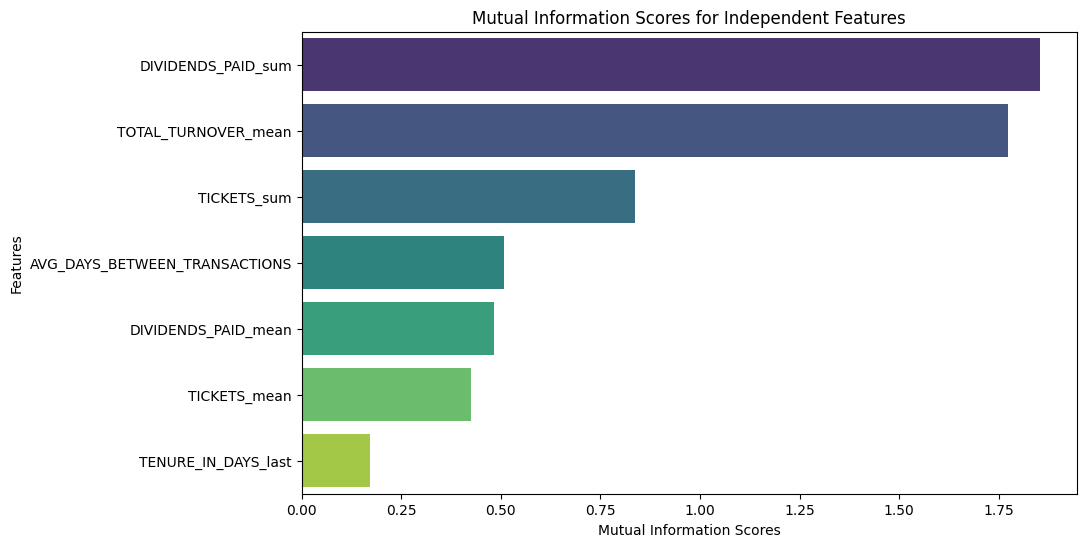

In [9]:

# Vẽ biểu đồ cột với Seaborn
plt.figure(figsize=(10,6))
sns.barplot(x='MI Scores', y=mi_scores_df.index, data=mi_scores_df, palette='viridis')
plt.xlabel('Mutual Information Scores')
plt.ylabel('Features')
plt.title('Mutual Information Scores for Independent Features')
plt.show()

In [10]:
df1.head()

,AVG_DAYS_BETWEEN_TRANSACTIONS,TENURE_IN_DAYS_last,FOB_RACING_TURNOVER_sum,FOB_SPORT_TURNOVER_sum,PARI_RACING_TURNOVER_sum,PARI_SPORT_TURNOVER_sum,TOTAL_TURNOVER_mean,TOTAL_TURNOVER_sum,TICKETS_mean,TICKETS_sum,DIVIDENDS_PAID_mean,DIVIDENDS_PAID_sum
0,1.577922,12575,331,0,460,0,790.898661,366186.08,245.414687,113627,584.918078,270817.07
1,3.681818,2613,179,1,78,0,160.969849,32033.00,4.226131,841,118.888744,23658.86
2,1.000000,0,1,0,1,0,100.000000,100.00,7.000000,7,760.000000,760.00
3,23.866667,358,3,13,0,0,9.687500,155.00,2.312500,37,9.340625,149.45
4,35.333333,106,3,1,2,0,7.500000,30.00,4.250000,17,0.000000,0.00


In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144869 entries, 0 to 144868
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   AVG_DAYS_BETWEEN_TRANSACTIONS  144869 non-null  float64
 1   TENURE_IN_DAYS_last            144869 non-null  int64  
 2   FOB_RACING_TURNOVER_sum        144869 non-null  int32  
 3   FOB_SPORT_TURNOVER_sum         144869 non-null  int32  
 4   PARI_RACING_TURNOVER_sum       144869 non-null  int32  
 5   PARI_SPORT_TURNOVER_sum        144869 non-null  int32  
 6   TOTAL_TURNOVER_mean            144869 non-null  float64
 7   TOTAL_TURNOVER_sum             144869 non-null  float64
 8   TICKETS_mean                   144869 non-null  float64
 9   TICKETS_sum                    144869 non-null  int64  
 10  DIVIDENDS_PAID_mean            144869 non-null  float64
 11  DIVIDENDS_PAID_sum             144869 non-null  float64
dtypes: float64(6), int32(4), int64

In [12]:
import pandas as pd
from sklearn.preprocessing import RobustScaler


numerical_cols = ['AVG_DAYS_BETWEEN_TRANSACTIONS', 'TENURE_IN_DAYS_last', 'FOB_RACING_TURNOVER_sum', 'FOB_SPORT_TURNOVER_sum', 'PARI_RACING_TURNOVER_sum',
                  'PARI_SPORT_TURNOVER_sum', '']
# Apply RobustScaler to the numerical columns
scaler = RobustScaler()
df1[numerical_cols] = scaler.fit_transform(df1[numerical_cols])

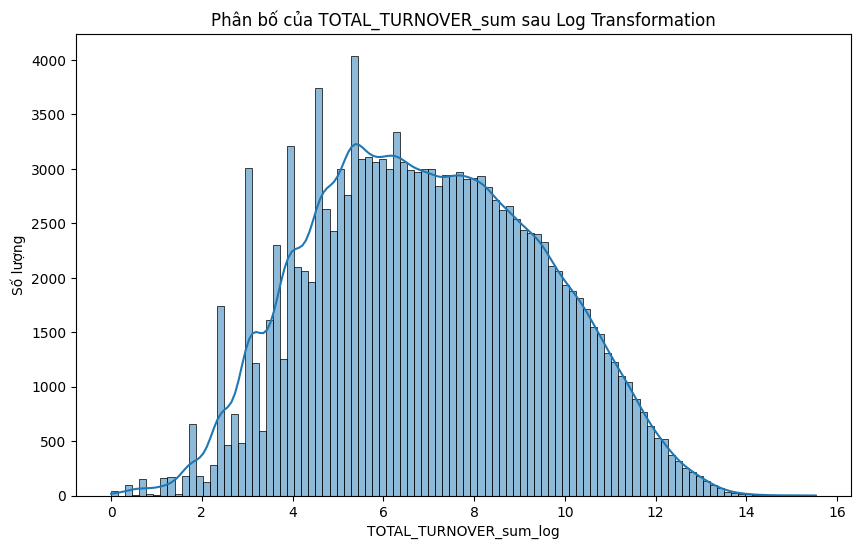

In [99]:
import numpy as np

# Áp dụng log transformation, cộng 1 để tránh log(0)
df1['TOTAL_TURNOVER_sum_log'] = np.log(df1['TOTAL_TURNOVER_sum'] + 1)

# Vẽ phân bố sau log transformation
plt.figure(figsize=(10, 6))
sns.histplot(df1['TOTAL_TURNOVER_sum_log'], bins=100, kde=True)
plt.title('Phân bố của TOTAL_TURNOVER_sum sau Log Transformation')
plt.xlabel('TOTAL_TURNOVER_sum_log')
plt.ylabel('Số lượng')
plt.show()


In [98]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Chia dữ liệu thành features và label
X = df1.drop('TOTAL_TURNOVER_sum', axis=1)  # Loại bỏ cột TOTAL_TURNOVER_sum để lấy features
y = df1['TOTAL_TURNOVER_sum']  # Nhãn là TOTAL_TURNOVER_sum

# 2. Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Xây dựng mô hình
model = RandomForestRegressor(n_estimators=100, random_state=42)

# 4. Huấn luyện mô hình
model.fit(X_train, y_train)

# 5. Đánh giá mô hình trên tập kiểm tra
predictions = model.predict(X_test)
# Tính MAE
mae = mean_absolute_error(y_test, predictions)

# Tính MSE và RMSE
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

# Tính R-squared
r2 = r2_score(y_test, predictions)

print(f'Mean Absolute Error: {mae:.3f}')
print(f'Mean Squared Error: {mse:.3f}')
print(f'Root Mean Squared Error: {rmse:.3f}')
print(f'R-squared: {r2:.3f}')


Mean Absolute Error: 1063.504
Mean Squared Error: 44660836.861
Root Mean Squared Error: 6682.876
R-squared: 0.987


In [100]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Chia dữ liệu thành features và label
X = df1.drop('TOTAL_TURNOVER_sum', axis=1)  # Loại bỏ cột TOTAL_TURNOVER_sum để lấy features
y = df1['TOTAL_TURNOVER_sum']  # Nhãn là TOTAL_TURNOVER_sum

# 2. Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Xây dựng mô hình
model = RandomForestRegressor(n_estimators=100, random_state=42)

# 4. Huấn luyện mô hình
model.fit(X_train, y_train)

# 5. Đánh giá mô hình trên tập kiểm tra
predictions = model.predict(X_test)
# Tính MAE
mae = mean_absolute_error(y_test, predictions)

# Tính MSE và RMSE
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

# Tính R-squared
r2 = r2_score(y_test, predictions)

print(f'Mean Absolute Error: {mae:.3f}')
print(f'Mean Squared Error: {mse:.3f}')
print(f'Root Mean Squared Error: {rmse:.3f}')
print(f'R-squared: {r2:.3f}')


Mean Absolute Error: 39.563
Mean Squared Error: 11657107.300
Root Mean Squared Error: 3414.251
R-squared: 0.997


In [101]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Chuẩn bị dữ liệu
X = df1.drop(['TOTAL_TURNOVER_sum'], axis=1)
y = df1['TOTAL_TURNOVER_sum']

# 2. Phân chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Xây dựng và huấn luyện mô hình
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                         max_depth = 5, alpha = 10, n_estimators = 100)
model.fit(X_train, y_train)

# 4. Đánh giá mô hình
y_pred = model.predict(X_test)
# Tính MAE
mae = mean_absolute_error(y_test, y_pred)

# Tính MSE và RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Tính R-squared
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.3f}')
print(f'Mean Squared Error: {mse:.3f}')
print(f'Root Mean Squared Error: {rmse:.3f}')
print(f'R-squared: {r2:.3f}')



Mean Absolute Error: 2162.497
Mean Squared Error: 207479981.908
Root Mean Squared Error: 14404.165
R-squared: 0.938


In [19]:
# Đếm số lượng giá trị khác nhau trong cột 'BET_ACCOUNT_NUM_HASH'
count_unique_values = df1['BET_ACCOUNT_NUM_HASH'].nunique()

print("Số lượng giá trị khác nhau trong cột 'BET_ACCOUNT_NUM_HASH':", count_unique_values)


Số lượng giá trị khác nhau trong cột 'BET_ACCOUNT_NUM_HASH': 144869


In [78]:
from sklearn.preprocessing import RobustScaler
# Các cột cần áp dụng Robust Scaler
columns_to_scale = ['FOB_RACING_TURNOVER', 'FOB_SPORT_TURNOVER', 'PARI_RACING_TURNOVER',
                    'PARI_SPORT_TURNOVER', 'TOTAL_TURNOVER', 'DIVIDENDS_PAID', 'TICKETS',
                    'AGE', 'TENURE_IN_DAYS']

# Khởi tạo RobustScaler
scaler = RobustScaler()

# Áp dụng Robust Scaler cho các cột
df1[columns_to_scale] = scaler.fit_transform(df1[columns_to_scale])
gender_mapping = {'M': 1, 'F': 0, 'U': 2}
df1['GENDER'] = df1['GENDER'].map(gender_mapping)
res_mapping = {'WA': 1, 'OTH': 0}
df1['RESIDENTIAL_STATE'] = df1['RESIDENTIAL_STATE'].map(res_mapping)
ageband_mapping = {'Unknown': 0, '18-24': 1, '25-34': 2, '35-44': 3, '45-54': 4, '55-64': 5, '65+': 6}
df1['AGE_BAND'] = df1['AGE_BAND'].map(ageband_mapping)

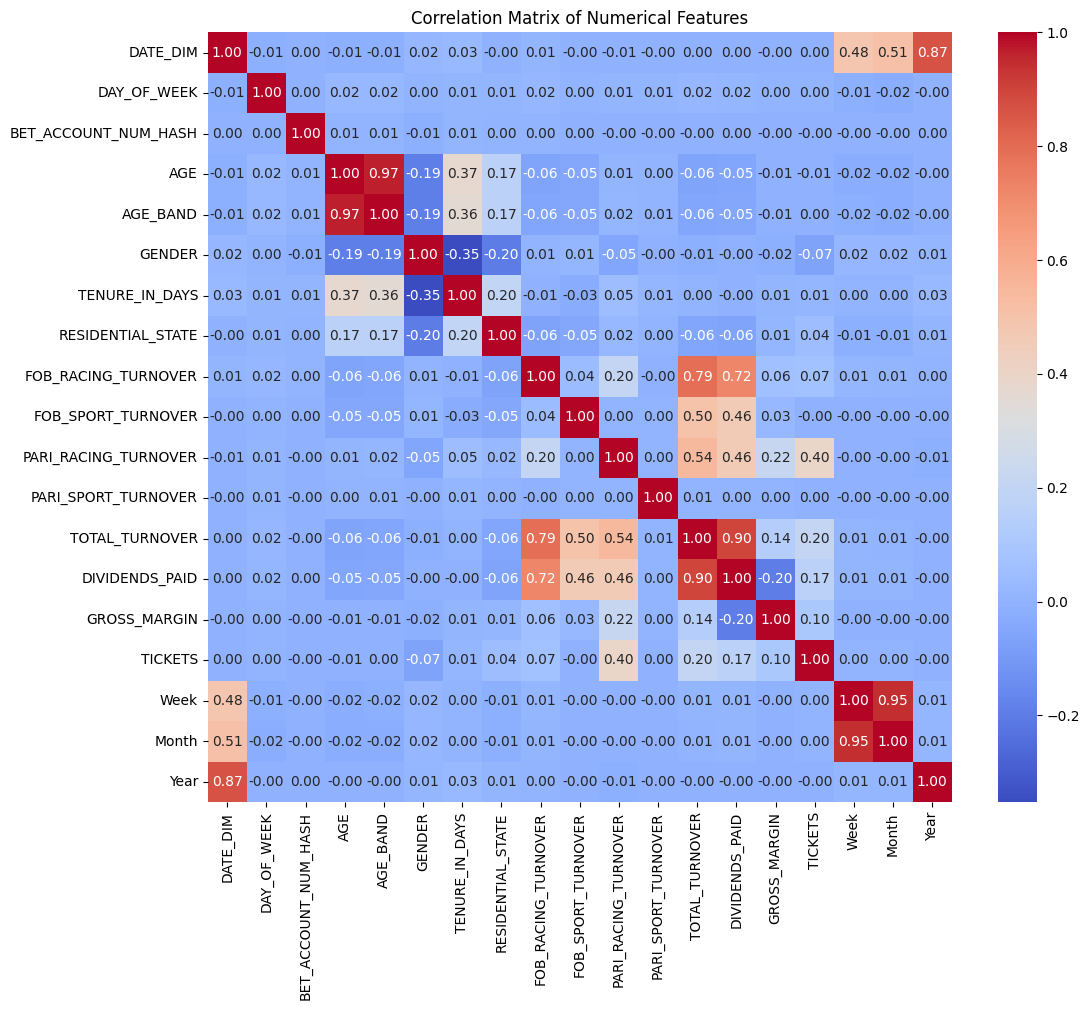

In [79]:
# Calculate the correlation matrix
correlation_matrix = df1.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


In [81]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
# Exclude non-numeric columns and retry
X = df1.drop(['GROSS_MARGIN', 'DATE_DIM'], axis=1)  # Dropping DATE_DIM as it's not a feature now
y = df1['GROSS_MARGIN']

# Since we've made changes, let's ensure GROSS_MARGIN is still our target and not part of X
if 'GROSS_MARGIN' in X:
    X = X.drop('GROSS_MARGIN', axis=1)

# Splitting the dataset into training and testing sets again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Re-initialize and re-train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Re-extracting feature importances
feature_importances = rf.feature_importances_

# Recreating a DataFrame to visualize the feature importances again
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

features_df


MemoryError: could not allocate 1073741824 bytes

In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Assuming 'data_filtered' is your DataFrame and it has a datetime index
# If it doesn't, ensure you set it with something like:
# data_filtered['DATE_DIM'] = pd.to_datetime(data_filtered['DATE_DIM'])
# data_filtered.set_index('DATE_DIM', inplace=True)

# Resample or aggregate GROSS_MARGIN by month (or your chosen period)
monthly_data = data_filtered['GROSS_MARGIN'].resample('M').sum()

# Decompose the time series
decomposition = seasonal_decompose(monthly_data, model='additive')

# Plot the decomposed time series components
plt.figure(figsize=(14, 7))
fig = decomposition.plot()
plt.show()


In [31]:
from sklearn.preprocessing import RobustScaler

# Các cột cần áp dụng Robust Scaler
columns_to_scale = ['FOB_RACING_TURNOVER', 'FOB_SPORT_TURNOVER', 'PARI_RACING_TURNOVER',
                    'PARI_SPORT_TURNOVER', 'TOTAL_TURNOVER', 'DIVIDENDS_PAID', 'TICKETS',
                    'AGE', 'TENURE_IN_DAYS']

# Khởi tạo RobustScaler
scaler = RobustScaler()

# Áp dụng Robust Scaler cho các cột
df1[columns_to_scale] = scaler.fit_transform(df1[columns_to_scale])


In [34]:
df1['AGE_BAND'].unique()

array(['65+', '45-54', '55-64', '25-34', '35-44', '18-24', 'Unknown'],
      dtype=object)

In [32]:
gender_mapping = {'M': 1, 'F': 0, 'U': 2}
df1['GENDER'] = df1['GENDER'].map(gender_mapping)

In [33]:
res_mapping = {'WA': 1, 'OTH': 0}
df1['RESIDENTIAL_STATE'] = df1['RESIDENTIAL_STATE'].map(res_mapping)

In [35]:
ageband_mapping = {'Unknown': 0, '18-24': 1, '25-34': 2, '35-44': 3, '45-54': 4, '55-64': 5, '65+': 6}
df1['AGE_BAND'] = df1['AGE_BAND'].map(ageband_mapping)

In [37]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12363655 entries, 0 to 12364100
Data columns (total 19 columns):
 #   Column                Dtype  
---  ------                -----  
 0   DATE_DIM              object 
 1   DAY_OF_WEEK           int64  
 2   BET_ACCOUNT_NUM_HASH  int64  
 3   AGE                   float64
 4   AGE_BAND              int64  
 5   GENDER                int64  
 6   TENURE_IN_DAYS        float64
 7   RESIDENTIAL_STATE     int64  
 8   FOB_RACING_TURNOVER   float64
 9   FOB_SPORT_TURNOVER    float64
 10  PARI_RACING_TURNOVER  float64
 11  PARI_SPORT_TURNOVER   float64
 12  TOTAL_TURNOVER        float64
 13  DIVIDENDS_PAID        float64
 14  GROSS_MARGIN          float64
 15  TICKETS               float64
 16  Week                  UInt32 
 17  Month                 int32  
 18  Year                  int32  
dtypes: UInt32(1), float64(10), int32(2), int64(5), object(1)
memory usage: 1.7+ GB


In [50]:
target_cols = ['DATE_DIM', 'Week']
df1 = df1.drop(target_cols, axis=1)

In [52]:
from sklearn.decomposition import PCA
import pandas as pd


# Khởi tạo PCA với số thành phần chính là 2
pca = PCA(n_components=7)

# Áp dụng PCA vào dữ liệu
principal_components = pca.fit_transform(df1)

# Tạo DataFrame mới từ các thành phần chính
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2','PC3','PC4','PC5', 'PC6', 'PC7'])

# In ra DataFrame mới sau khi áp dụng PCA
print(df_pca)


MemoryError: Unable to allocate 1.57 GiB for an array with shape (17, 12363655) and data type float64

# V. TRAIN - VALID - TEST SPLIT

CHia dữ liệu ra 9:0,5:0,5

# VI. FORECASTING

DÙNG DEEP LEARNING ĐỂ LÀM VÀ DỰ ĐOÁN

# VII. EVALUATION